In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from myPytorchModels import TimeSeriesTransformer
from csv2numpy import prepTimeSeqData

In [2]:
# Prepare the Data ---------------------------------------------------------------------

seq_len = 64  # sequence length

fs, feature_names, feature_correction, Xs, Ys, X, Y, _, _, _, _, Us, U = prepTimeSeqData(seq_len=seq_len, maxNumel=1e9, hzn_len=1)
Xs = torch.tensor(Xs, dtype=torch.float32)
Ys = torch.tensor(Ys, dtype=torch.float32)
Us = torch.tensor(Us, dtype=torch.float32)
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
U = torch.tensor(U, dtype=torch.float32)

num_feat = len(feature_names)

Sampling frequency (Hz): 1000.0
Baseline Pairs created: 79359
Input shape : (79359, 64, 192)
Output shape: (79359, 192)
Event shape: (79359, 1, 1)
Main Pairs created: 74997
Input shape : (74997, 64, 192)
Output shape: (74997, 192)
Event shape: (74997, 1, 1)


In [3]:
# Initialize the Model, Loss Function, and Optimizer

test_size=0.8
batch_size = 32

groupsize = 16

model = TimeSeriesTransformer(dim_in=num_feat, dim_out=num_feat, time_len=seq_len, group_size=groupsize, num_groups=4, tuple_size=3)
#model = Seq2SeqTimeSeriesTransformer(dim_in=num_feat, dim_out=num_feat, seq_len=seq_len, horizon=hzn_len, dim_model=8, num_heads=2, num_encoder_layers=2, num_decoder_layers=2, dim_ff=16)
criterion = nn.MSELoss()

# train / test
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size, random_state=42)
train_N = int((1 - test_size) * len(X))
X_train = X[:train_N]
Y_train = Y[:train_N]
U_train = U[:train_N]
X_test = X[train_N:]
Y_test = Y[train_N:]
U_test = U[train_N:]

train_N_s = int((1 - test_size) * len(Xs))
Xs_train = Xs[:train_N_s]
Ys_train = Ys[:train_N_s]
Us_train = Us[:train_N_s]
Xs_test = Xs[train_N_s:]
Ys_test = Ys[train_N_s:]
Us_test = Us[train_N_s:]

# Create TensorDatasets
train_dataset = TensorDataset(X_train, Y_train, U_train)
test_dataset = TensorDataset(X_test, Y_test, U_test)
train_dataset_s = TensorDataset(Xs_train, Ys_train, Us_train)
test_dataset_s = TensorDataset(Xs_test, Ys_test, Us_test)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
all_loader = DataLoader(TensorDataset(X, Y, U), shuffle=False)
train_loader_s = DataLoader(train_dataset_s, batch_size, shuffle=True)
test_loader_s = DataLoader(test_dataset_s, batch_size, shuffle=False)
all_loader_s = DataLoader(TensorDataset(Xs, Ys, Us), shuffle=False)

In [4]:
# data baseline characteristics as reference for loss 
mean_y = Y_train.mean(dim=0)
std_y = Y_train.std(dim=0)
var_y = std_y ** 2
var_per_feat = np.var(Y_train.numpy(), axis=0)  # redundant?

Epoch 1/5 — train_loss: 0.244893, val_loss: 0.172426
Epoch 2/5 — train_loss: 0.145709, val_loss: 0.124351
Epoch 3/5 — train_loss: 0.116093, val_loss: 0.108270
Epoch 4/5 — train_loss: 0.105896, val_loss: 0.101565
Epoch 5/5 — train_loss: 0.101736, val_loss: 0.099389
Epoch 1/5 — train_loss: 0.110384, val_loss: 0.106817
Epoch 2/5 — train_loss: 0.106448, val_loss: 0.103875
Epoch 3/5 — train_loss: 0.103672, val_loss: 0.102202
Epoch 4/5 — train_loss: 0.101873, val_loss: 0.100585
Epoch 5/5 — train_loss: 0.099646, val_loss: 0.097384


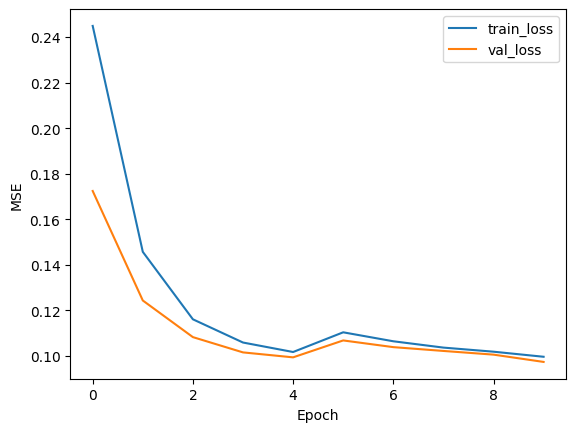

In [5]:
# Step 4: Train the Model
optimizer = optim.Adam(model.parameters(), lr=0.001)

# start by performing a few epochs on each set 

model.train()
num_epochs = 5 # max
patience = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- train ---
    model.train()
    running_loss = 0.0
    for X_batch, Y_batch, U_batch in train_loader:
        # Forward pass
        Y_pred = model(X_batch, U_batch)
        loss = criterion(Y_pred, Y_batch)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- validate ---
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for X_val, Y_val, U_val in test_loader:   # use test_loader or a separate val_loader
            Y_val_pred = model(X_val, U_val)
            l = criterion(Y_val_pred, Y_val)
            val_running += l.item() * X_val.size(0)
    epoch_val_loss = val_running / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — train_loss: {epoch_train_loss:.6f}, val_loss: {epoch_val_loss:.6f}")

for epoch in range(num_epochs):
    # --- train ---
    model.train()
    running_loss = 0.0
    for X_batch, Y_batch, U_batch in train_loader_s:
        # Forward pass
        Y_pred = model(X_batch, U_batch)
        loss = criterion(Y_pred, Y_batch)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / len(train_loader_s.dataset)
    train_losses.append(epoch_train_loss)

    # --- validate ---
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for X_val, Y_val, U_val in test_loader_s:   # use test_loader or a separate val_loader
            Y_val_pred = model(X_val, U_val)
            l = criterion(Y_val_pred, Y_val)
            val_running += l.item() * X_val.size(0)
    epoch_val_loss = val_running / len(test_loader_s.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — train_loss: {epoch_train_loss:.6f}, val_loss: {epoch_val_loss:.6f}")

# After loop: plot train/val loss to inspect convergence
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

Train samples: 15871
Batch size: 32
Batches/epoch: 496
Epoch 1/100 — train_loss: 0.093611, val_loss: 0.089907
Epoch 2/100 — train_loss: 0.090602, val_loss: 0.088006
Epoch 3/100 — train_loss: 0.089394, val_loss: 0.087204
Epoch 4/100 — train_loss: 0.088792, val_loss: 0.086816
Epoch 5/100 — train_loss: 0.088088, val_loss: 0.086244
Epoch 6/100 — train_loss: 0.087545, val_loss: 0.085443
Epoch 7/100 — train_loss: 0.087067, val_loss: 0.085230
Epoch 8/100 — train_loss: 0.086602, val_loss: 0.084962
Epoch 9/100 — train_loss: 0.086217, val_loss: 0.084814
Epoch 10/100 — train_loss: 0.085800, val_loss: 0.084723
Epoch 11/100 — train_loss: 0.085390, val_loss: 0.084718
Epoch 12/100 — train_loss: 0.085090, val_loss: 0.084263
Epoch 13/100 — train_loss: 0.084695, val_loss: 0.084424
Epoch 14/100 — train_loss: 0.084275, val_loss: 0.084000
Epoch 15/100 — train_loss: 0.083940, val_loss: 0.083879
Epoch 16/100 — train_loss: 0.083554, val_loss: 0.083798
Epoch 17/100 — train_loss: 0.083194, val_loss: 0.083842
Ep

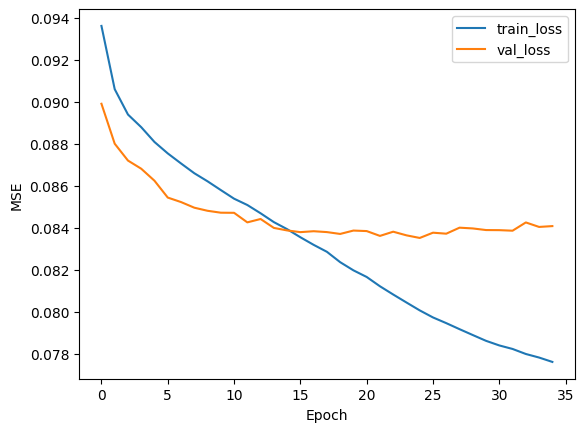

In [6]:
# Step 4A: full training on baseline data 

train_size = len(train_loader.dataset)
steps_per_epoch = math.ceil(train_size / batch_size)
print("Train samples:", train_size)
print("Batch size:", batch_size)
print("Batches/epoch:", steps_per_epoch)

model.train()
num_epochs = 100 # max
patience = 10
best_val = float('inf')
no_improve = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- train ---
    model.train()
    running_loss = 0.0
    for X_batch, Y_batch, U_batch in train_loader:
        # Forward pass
        Y_pred = model(X_batch, U_batch)
        loss = criterion(Y_pred, Y_batch)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / train_size
    train_losses.append(epoch_train_loss)

    # --- validate ---
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for X_val, Y_val, U_val in test_loader:   # use test_loader or a separate val_loader
            Y_val_pred = model(X_val, U_val)
            l = criterion(Y_val_pred, Y_val)
            val_running += l.item() * X_val.size(0)
    epoch_val_loss = val_running / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — train_loss: {epoch_train_loss:.6f}, val_loss: {epoch_val_loss:.6f}")

    # --- Early stopping ---
    if epoch_val_loss < best_val - 1e-9:
        best_val = epoch_val_loss
        no_improve = 0
        # Optionally save best model:
        # torch.save(model.state_dict(), "neural_network_pytorch.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"No improvement for {patience} epochs — stopping early at epoch {epoch+1}.")
            break

# After loop: plot train/val loss to inspect convergence
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
# load or save model
# model.load_state_dict(torch.load("neural_network_pytorch.pth"))
# torch.save(model.state_dict(), "neural_network_pytorch.pth")

Test Loss: 0.0841


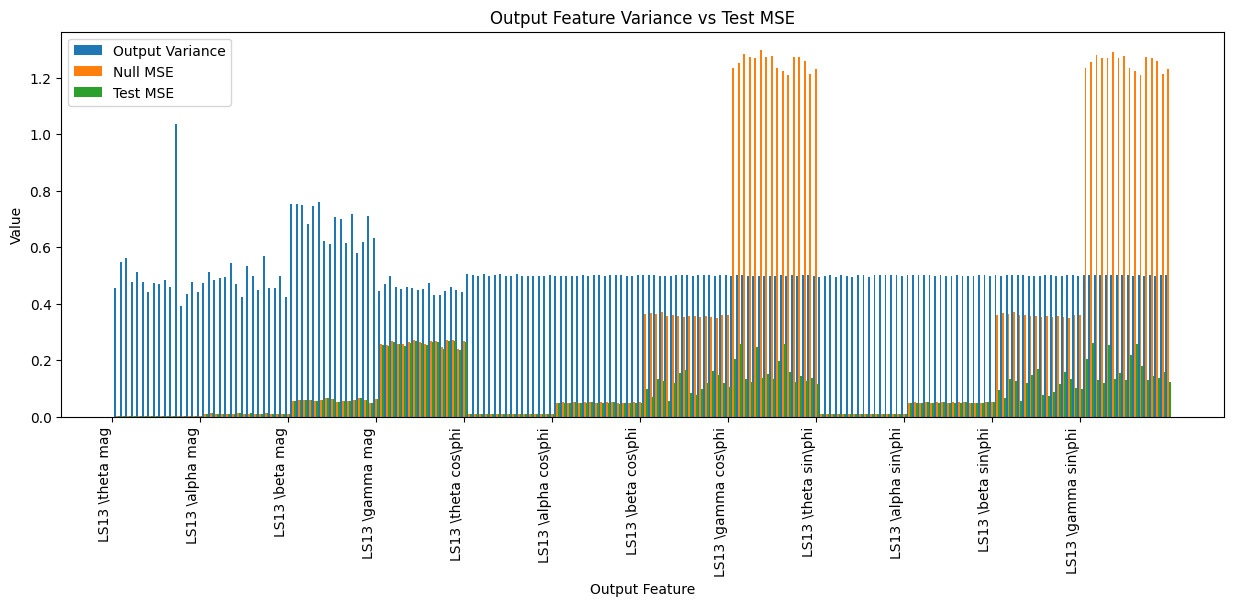

In [8]:
# Step 5A: Evaluate the Model on Test Data

Y_pred = []
Y_test1 = []

model.eval()
with torch.no_grad():
    total_loss = 0
    for x_batch, y_batch, u_batch in test_loader:
        y_pred = model(x_batch, u_batch)
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item() * x_batch.size(0)  # sum up batch loss
        if y_pred.shape[0] == batch_size:
            Y_pred.append(y_pred)
            Y_test1.append(y_batch)

    avg_loss = total_loss / len(test_dataset)
    print(f"Test Loss: {avg_loss:.4f}")

Y_pred_np = np.array(Y_pred)
Y_pred_np = Y_pred_np.reshape(-1, num_feat)
Y_test_np = Y_test.numpy()
Y_test1_np = np.array(Y_test1)
Y_test1_np = Y_test1_np.reshape(-1, num_feat)

Y_null_all_np = X.numpy()[:, -1, :Y.shape[1]]
Y_null_test_np = X_test.numpy()[:, -1, :Y.shape[1]]

MSE_per_feat = np.mean((Y_test1_np - Y_pred_np) ** 2, axis=0)
MSE_per_feat_null = np.mean((Y_test_np - Y_null_test_np) ** 2, axis=0)
feats = np.arange(1, Y.shape[1]+1)
barwid = .35

plt.figure(figsize=(15,5))
plt.bar(feats - barwid, var_per_feat, width=barwid, label='Output Variance')
plt.bar(feats, MSE_per_feat_null, width=barwid, label='Null MSE')
plt.bar(feats + barwid, MSE_per_feat, width=barwid, label='Test MSE')
plt.xlabel('Output Feature')
plt.xticks(ticks=range(0, len(feats), groupsize), labels=feature_names[::groupsize], rotation=90, ha='right')
plt.ylabel('Value')
plt.title('Output Feature Variance vs Test MSE')
plt.legend()
plt.show()

MSE_per_feat = MSE_per_feat / (np.mean(Y_test1_np**2, axis=0) + np.finfo(float).eps)
MSE_per_feat_null = MSE_per_feat_null / (np.mean(Y_test_np**2, axis=0) + np.finfo(float).eps)

In [9]:
X_all_np = X.numpy()
Y_all_np = Y.numpy()
U_all_np = U.numpy()

Y_all_pred = []

model.eval()
with torch.no_grad():
    total_loss = 0
    for x_batch, y_batch, u_batch in all_loader:
        y_pred = model(x_batch, u_batch)
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item() * x_batch.size(0)  # sum up batch loss
        Y_all_pred.append(y_pred)

    avg_loss = total_loss / len(test_dataset)
    print(f"Test+Train Loss: {avg_loss:.4f}")

Y_pred_all_np = np.array(Y_all_pred)
Y_pred_all_np = Y_pred_all_np.reshape(-1, num_feat)

Test+Train Loss: 0.1028


In [10]:
# simulations 
simdur = int(0.2 * fs) # samples 
plotdomain = 1000 * np.array([-1, 1]) + train_N

Ysim = []
i0 = plotdomain[0]
model.eval()
while i0+simdur < plotdomain[1]:
    xi = torch.tensor(X_all_np[i0, :, :].reshape(1,-1,X.shape[-1]), dtype=torch.float32)
    for i in range(simdur):
        #ui = torch.tensor(U_all_np[i0:i0+i+1,0:1,:], dtype=torch.float32) # use rollout
        ui = torch.tensor(U_all_np[i0+i:i0+i+1,0:1,:], dtype=torch.float32) # do not use rollout
        ui = ui.permute(1,0,2)
        ui = 0 * ui
        with torch.no_grad():
            yi = model(xi, ui)
        Ysim.append(yi.numpy().flatten())
        xi = torch.cat([xi[0, 1:, :], yi], dim=0).reshape(1,-1,X.shape[-1]) # remove line to enable rollout
    i0 += simdur
    print("Simulating:", (i0-plotdomain[0])/(plotdomain[1]-plotdomain[0]), " complete." )

Ysim = np.array(Ysim)
plotxval = np.arange(len(Ysim)) + plotdomain[0]

Simulating: 0.1  complete.
Simulating: 0.2  complete.
Simulating: 0.3  complete.
Simulating: 0.4  complete.
Simulating: 0.5  complete.
Simulating: 0.6  complete.
Simulating: 0.7  complete.
Simulating: 0.8  complete.
Simulating: 0.9  complete.


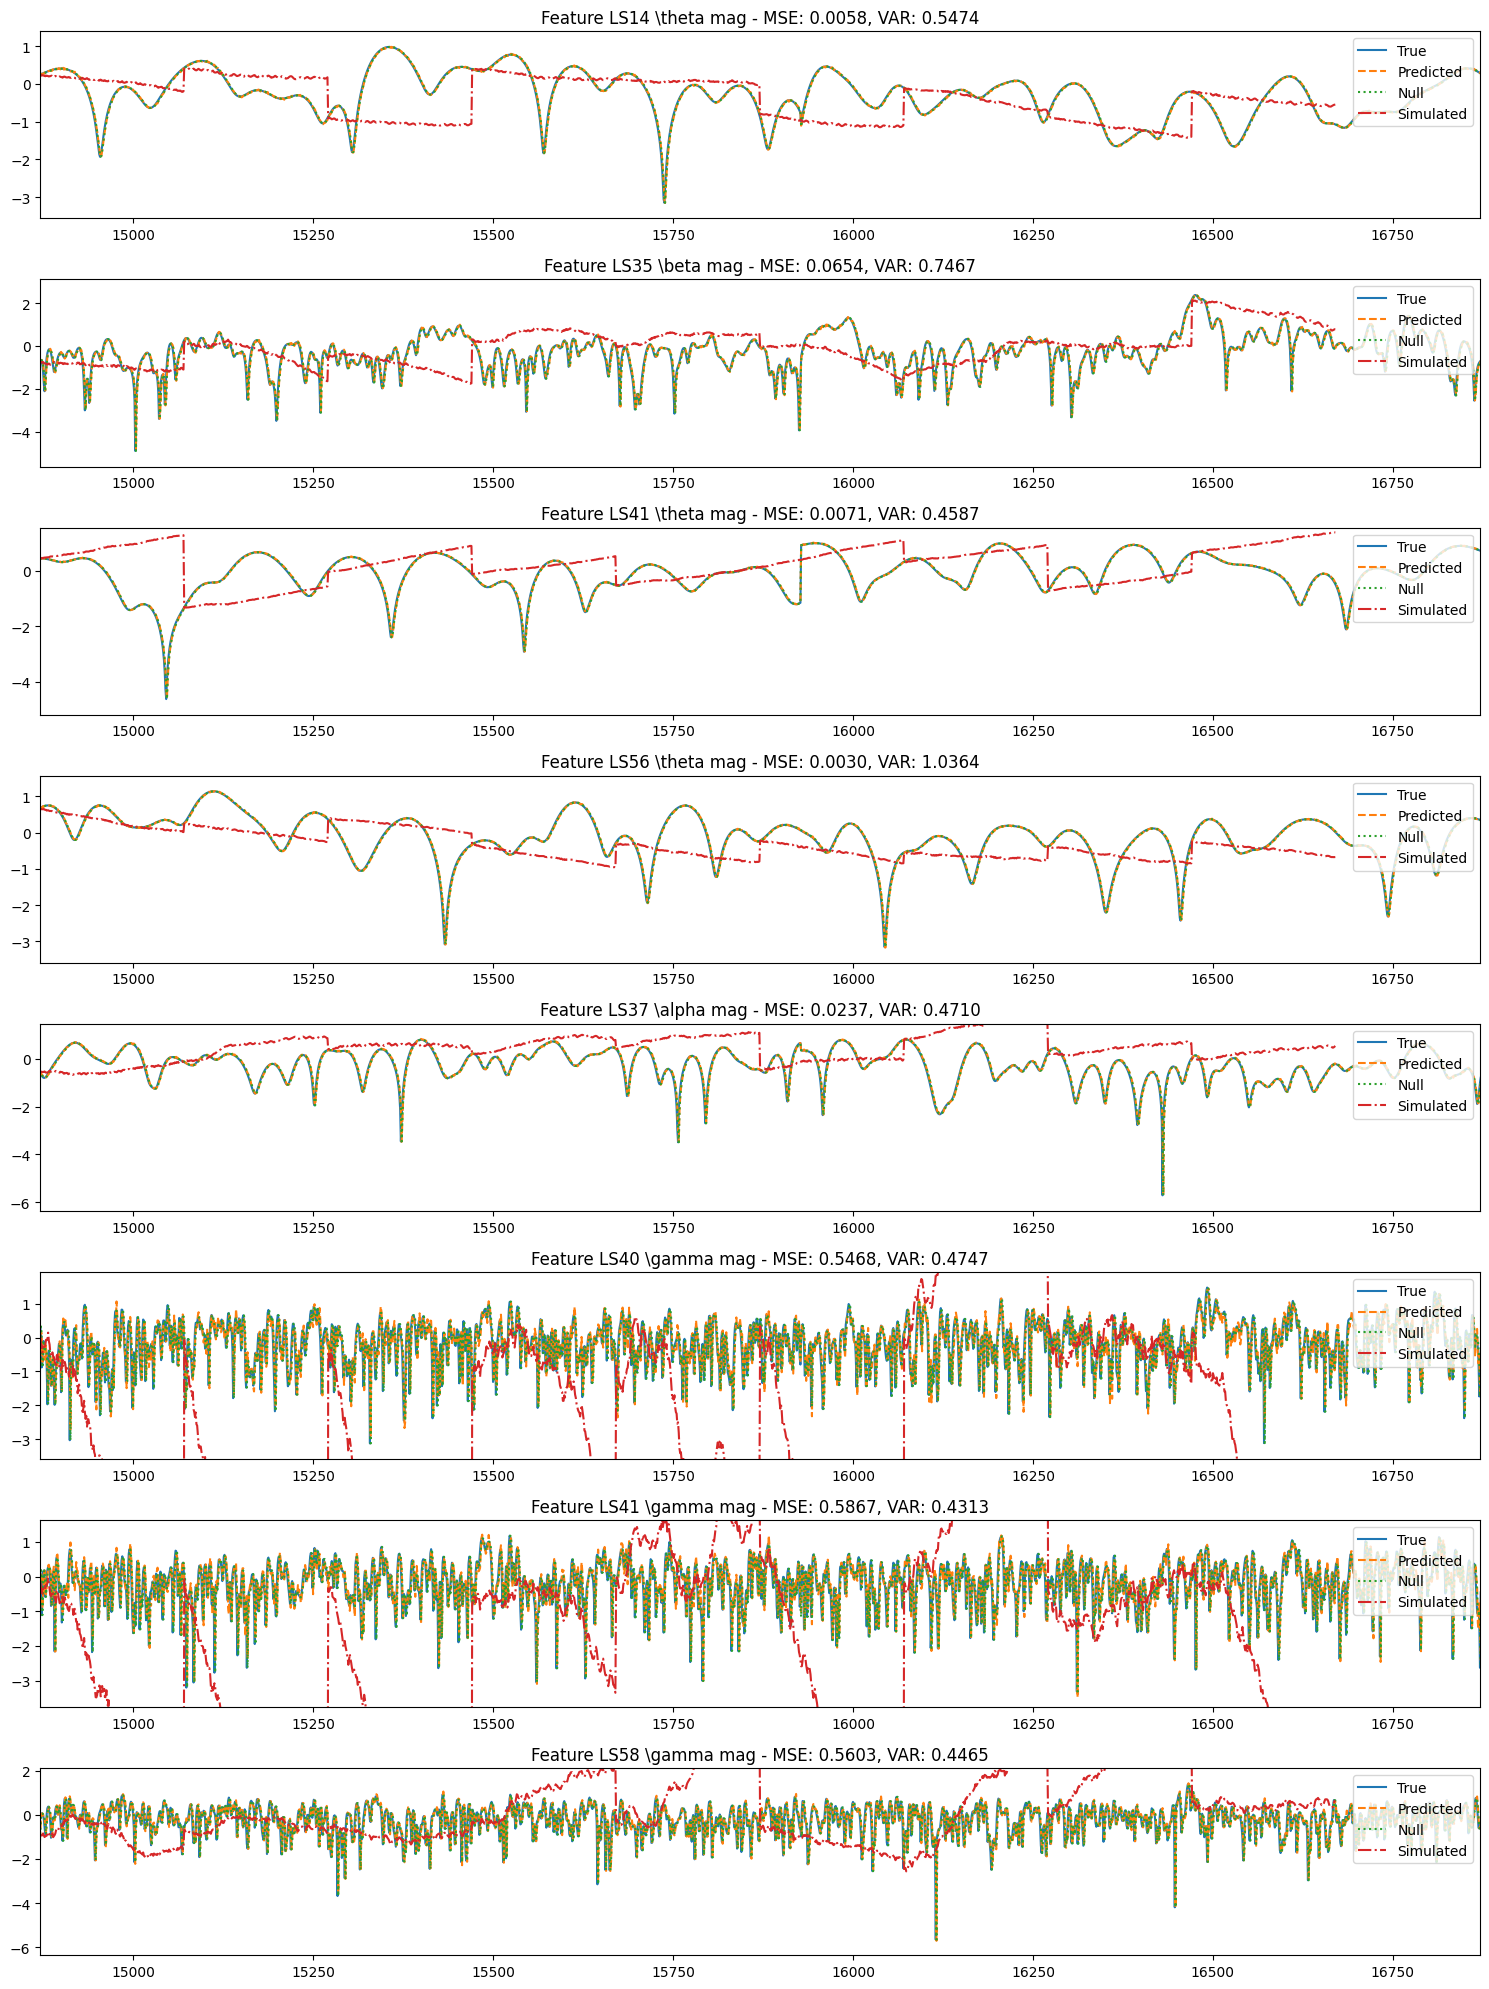

In [11]:
# show several examples 

iMSE = np.argsort(MSE_per_feat)
iVAR = np.argsort(var_per_feat)
iLRN = np.argsort(MSE_per_feat / (var_per_feat + np.finfo(float).eps))
iToPlot = [iMSE[:2], iMSE[-2:], iVAR[:2], iVAR[-2:], iLRN[:2], iLRN[-2:]]
iToPlot = list(set([i for sublist in iToPlot for i in sublist]))
iToPlot = [i-1 for i in iToPlot]  # adjust for zero indexing

plt.figure(figsize=(15,20))
iPlot = 1
for i in iToPlot:
    plt.subplot(len(iToPlot), 1, iPlot)
    plt.plot(Y_all_np[:, i], label='True')
    plt.plot(Y_pred_all_np[:, i], label='Predicted', linestyle='--')
    plt.plot(Y_null_all_np[:, i], label='Null', linestyle=':')
    plt.plot(plotxval, Ysim[:,i], label='Simulated', linestyle='-.')
    plt.xlim(plotdomain)

    # set the y limits to be slightly larger than the min/max of true values in the plotdomain
    y_min = np.min(Y_all_np[plotdomain[0]:plotdomain[1], i])
    y_max = np.max(Y_all_np[plotdomain[0]:plotdomain[1], i])
    y_range = y_max - y_min
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    
    plt.title(f'Feature {feature_names[i]} - MSE: {MSE_per_feat[i]:.4f}, VAR: {var_per_feat[i]:.4f}')
    plt.legend(loc='upper right')
    iPlot += 1
plt.tight_layout()
plt.show()

Train samples: 14999
Batch size: 32
Batches/epoch: 469
Epoch 1/100 — train_loss: 0.095980, val_loss: 0.091876
Epoch 2/100 — train_loss: 0.092568, val_loss: 0.091031
Epoch 3/100 — train_loss: 0.091398, val_loss: 0.090275
Epoch 4/100 — train_loss: 0.090547, val_loss: 0.089493
Epoch 5/100 — train_loss: 0.089739, val_loss: 0.089323
Epoch 6/100 — train_loss: 0.088852, val_loss: 0.089316
Epoch 7/100 — train_loss: 0.088080, val_loss: 0.088926
Epoch 8/100 — train_loss: 0.087372, val_loss: 0.089310
Epoch 9/100 — train_loss: 0.086761, val_loss: 0.089138
Epoch 10/100 — train_loss: 0.086190, val_loss: 0.088900
Epoch 11/100 — train_loss: 0.085645, val_loss: 0.089138
Epoch 12/100 — train_loss: 0.085199, val_loss: 0.088878
Epoch 13/100 — train_loss: 0.084793, val_loss: 0.089045
Epoch 14/100 — train_loss: 0.084399, val_loss: 0.089074
Epoch 15/100 — train_loss: 0.084055, val_loss: 0.088962
Epoch 16/100 — train_loss: 0.083725, val_loss: 0.089034
Epoch 17/100 — train_loss: 0.083439, val_loss: 0.089112
Ep

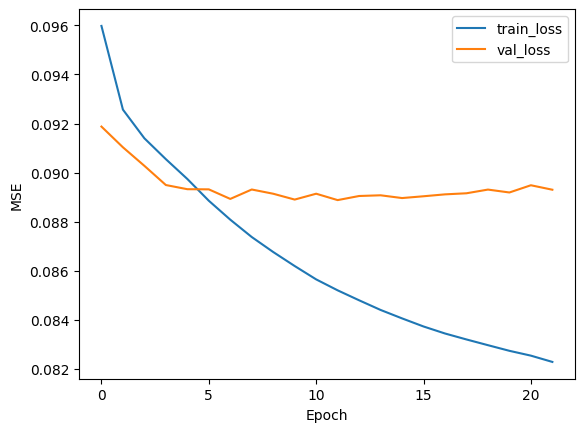

In [12]:
# Step 4B: full training on main data 

train_size = len(train_loader_s.dataset)
steps_per_epoch = math.ceil(train_size / batch_size)
print("Train samples:", train_size)
print("Batch size:", batch_size)
print("Batches/epoch:", steps_per_epoch)

model.train()
num_epochs = 100 # max
patience = 10
best_val = float('inf')
no_improve = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- train ---
    model.train()
    running_loss = 0.0
    for X_batch, Y_batch, U_batch in train_loader_s:
        # Forward pass
        Y_pred = model(X_batch, U_batch)
        loss = criterion(Y_pred, Y_batch)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / train_size
    train_losses.append(epoch_train_loss)

    # --- validate ---
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for X_val, Y_val, U_val in test_loader_s:   # use test_loader or a separate val_loader
            Y_val_pred = model(X_val, U_val)
            l = criterion(Y_val_pred, Y_val)
            val_running += l.item() * X_val.size(0)
    epoch_val_loss = val_running / len(test_loader_s.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — train_loss: {epoch_train_loss:.6f}, val_loss: {epoch_val_loss:.6f}")

    # --- Early stopping ---
    if epoch_val_loss < best_val - 1e-9:
        best_val = epoch_val_loss
        no_improve = 0
        # Optionally save best model:
        # torch.save(model.state_dict(), "neural_network_pytorch.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"No improvement for {patience} epochs — stopping early at epoch {epoch+1}.")
            break

# After loop: plot train/val loss to inspect convergence
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

Test Loss: 0.0893


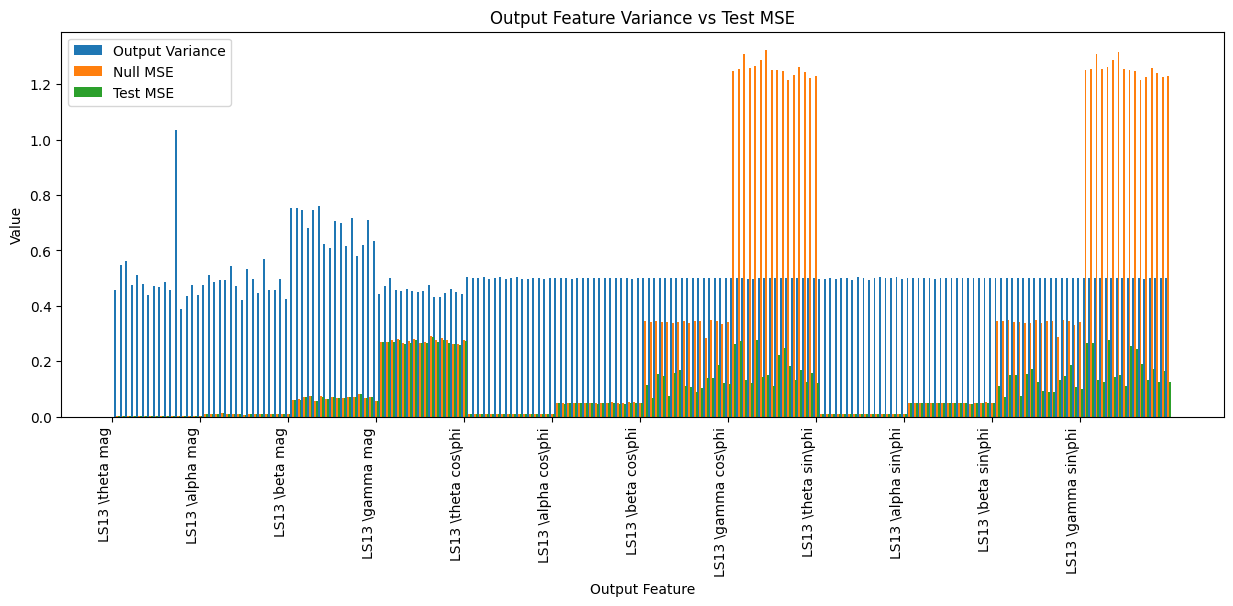

In [13]:
# Step 5B: Evaluate the Model on Test Data

Y_pred = []
Y_test1 = []

model.eval()
with torch.no_grad():
    total_loss = 0
    for x_batch, y_batch, u_batch in test_loader_s:
        y_pred = model(x_batch, u_batch)
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item() * x_batch.size(0)  # sum up batch loss
        if y_pred.shape[0] == batch_size:
            Y_pred.append(y_pred)
            Y_test1.append(y_batch)

    avg_loss = total_loss / len(test_dataset_s)
    print(f"Test Loss: {avg_loss:.4f}")

Y_pred_np = np.array(Y_pred)
Y_pred_np = Y_pred_np.reshape(-1, num_feat)
Y_test_np = Ys_test.numpy()
Y_test1_np = np.array(Y_test1)
Y_test1_np = Y_test1_np.reshape(-1, num_feat)

Y_null_all_np = Xs.numpy()[:, -1, :Ys.shape[1]]
Y_null_test_np = Xs_test.numpy()[:, -1, :Ys.shape[1]]

MSE_per_feat = np.mean((Y_test1_np - Y_pred_np) ** 2, axis=0)
MSE_per_feat_null = np.mean((Y_test_np - Y_null_test_np) ** 2, axis=0)
feats = np.arange(1, Ys.shape[1]+1)
barwid = .35

plt.figure(figsize=(15,5))
plt.bar(feats - barwid, var_per_feat, width=barwid, label='Output Variance')
plt.bar(feats, MSE_per_feat_null, width=barwid, label='Null MSE')
plt.bar(feats + barwid, MSE_per_feat, width=barwid, label='Test MSE')
plt.xlabel('Output Feature')
plt.xticks(ticks=range(0, len(feats), groupsize), labels=feature_names[::groupsize], rotation=90, ha='right')
plt.ylabel('Value')
plt.title('Output Feature Variance vs Test MSE')
plt.legend()
plt.show()

MSE_per_feat = MSE_per_feat / (np.mean(Y_test1_np**2, axis=0) + np.finfo(float).eps)
MSE_per_feat_null = MSE_per_feat_null / (np.mean(Y_test_np**2, axis=0) + np.finfo(float).eps)

In [14]:
X_all_np = Xs.numpy()
Y_all_np = Ys.numpy()
U_all_np = Us.numpy()

Y_all_pred = []

model.eval()
with torch.no_grad():
    total_loss = 0
    for x_batch, y_batch, u_batch in all_loader_s:
        y_pred = model(x_batch, u_batch)
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item() * x_batch.size(0)  # sum up batch loss
        Y_all_pred.append(y_pred)

    avg_loss = total_loss / len(test_dataset_s)
    print(f"Test+Train Loss: {avg_loss:.4f}")

Y_pred_all_np = np.array(Y_all_pred)
Y_pred_all_np = Y_pred_all_np.reshape(-1, num_feat)

Test+Train Loss: 0.1092


In [15]:
# simulations 
simdur = int(0.2 * fs) # samples 
plotdomain = 5000 * np.array([-1, 1]) + train_N_s

Ysim = []
i0 = plotdomain[0]
model.eval()
while i0+simdur < plotdomain[1]:
    xi = torch.tensor(X_all_np[i0, :, :].reshape(1,-1,X.shape[-1]), dtype=torch.float32)
    for i in range(simdur):
        #ui = torch.tensor(U_all_np[i0:i0+i+1,0:1,:], dtype=torch.float32) # use rollout
        ui = torch.tensor(U_all_np[i0+i:i0+i+1,0:1,:], dtype=torch.float32) # do not use rollout
        ui = ui.permute(1,0,2)
        ui = 0 * ui
        with torch.no_grad():
            yi = model(xi, ui)
        Ysim.append(yi.numpy().flatten())
        xi = torch.cat([xi[0, 1:, :], yi], dim=0).reshape(1,-1,X.shape[-1]) # remove line to enable rollout
    i0 += simdur
    print("Simulating:", (i0-plotdomain[0])/(plotdomain[1]-plotdomain[0]), " complete." )

Ysim = np.array(Ysim)
plotxval = np.arange(len(Ysim)) + plotdomain[0]

Simulating: 0.02  complete.
Simulating: 0.04  complete.
Simulating: 0.06  complete.
Simulating: 0.08  complete.
Simulating: 0.1  complete.
Simulating: 0.12  complete.
Simulating: 0.14  complete.
Simulating: 0.16  complete.
Simulating: 0.18  complete.
Simulating: 0.2  complete.
Simulating: 0.22  complete.
Simulating: 0.24  complete.
Simulating: 0.26  complete.
Simulating: 0.28  complete.
Simulating: 0.3  complete.
Simulating: 0.32  complete.
Simulating: 0.34  complete.
Simulating: 0.36  complete.
Simulating: 0.38  complete.
Simulating: 0.4  complete.
Simulating: 0.42  complete.
Simulating: 0.44  complete.
Simulating: 0.46  complete.
Simulating: 0.48  complete.
Simulating: 0.5  complete.
Simulating: 0.52  complete.
Simulating: 0.54  complete.
Simulating: 0.56  complete.
Simulating: 0.58  complete.
Simulating: 0.6  complete.
Simulating: 0.62  complete.
Simulating: 0.64  complete.
Simulating: 0.66  complete.
Simulating: 0.68  complete.
Simulating: 0.7  complete.
Simulating: 0.72  complete.

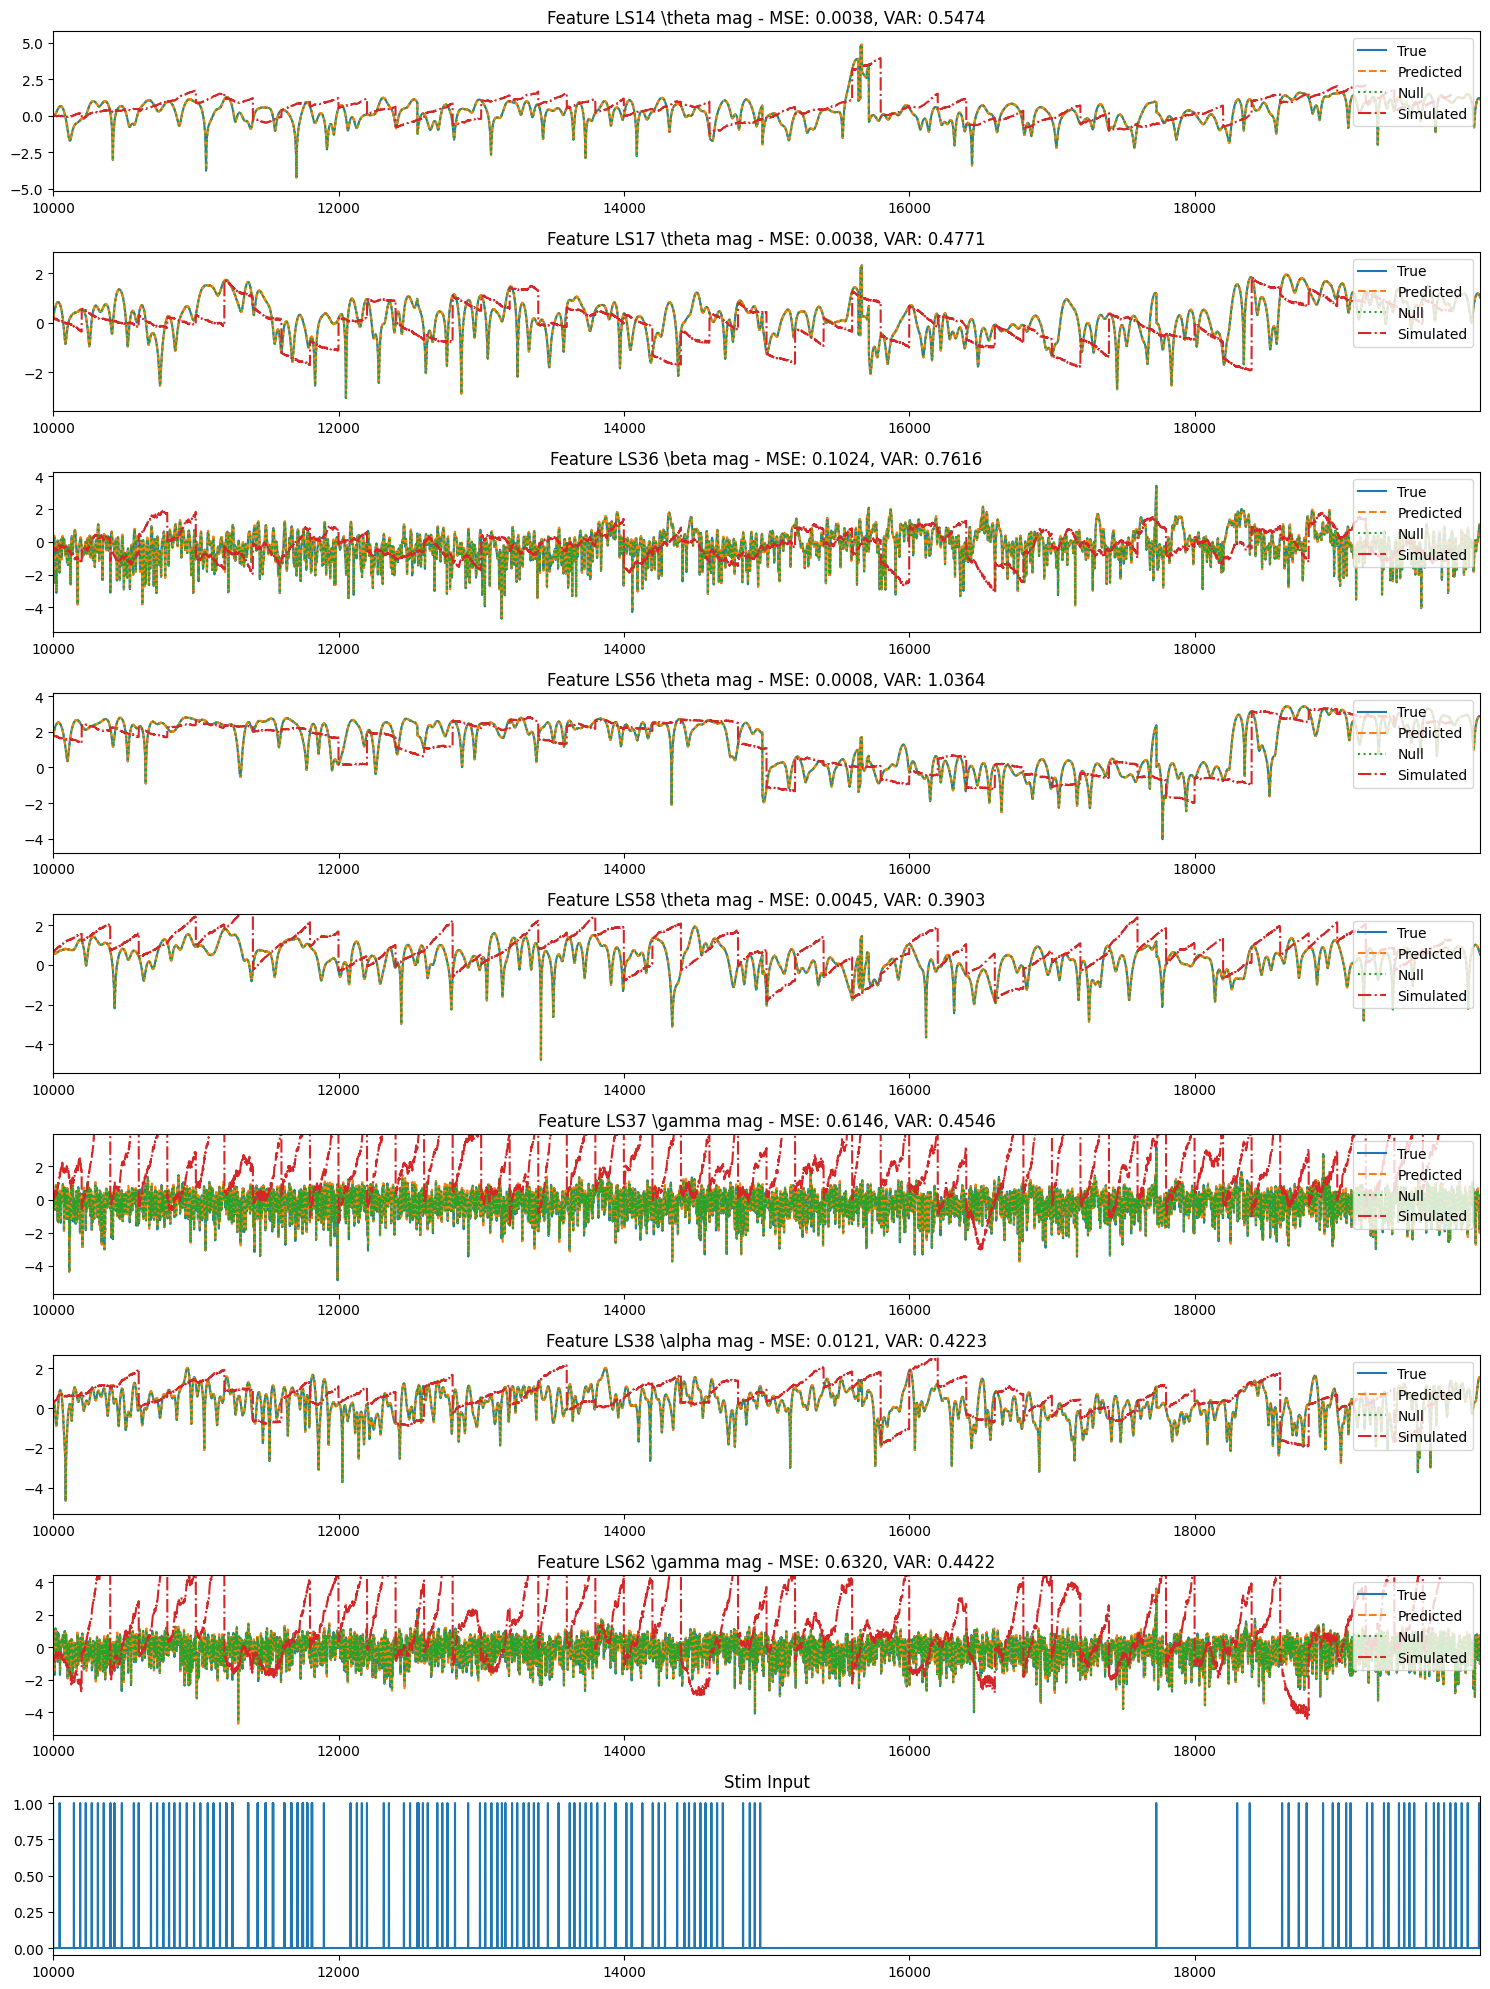

In [16]:
# show several examples 

iMSE = np.argsort(MSE_per_feat)
iVAR = np.argsort(var_per_feat)
iLRN = np.argsort(MSE_per_feat / var_per_feat)
iToPlot = [iMSE[:2], iMSE[-2:], iVAR[:2], iVAR[-2:], iLRN[:2], iLRN[-2:]]
iToPlot = list(set([i for sublist in iToPlot for i in sublist]))

plt.figure(figsize=(15,20))
iPlot = 1
for i in iToPlot:
    plt.subplot(len(iToPlot)+1, 1, iPlot)
    plt.plot(Y_all_np[:, i], label='True')
    plt.plot(Y_pred_all_np[:, i], label='Predicted', linestyle='--')
    plt.plot(Y_null_all_np[:, i], label='Null', linestyle=':')
    plt.plot(plotxval, Ysim[:,i], label='Simulated', linestyle='-.')
    plt.xlim(plotdomain)

    # set the y limits to be slightly larger than the min/max of true values in the plotdomain
    y_min = np.min(Y_all_np[plotdomain[0]:plotdomain[1], i])
    y_max = np.max(Y_all_np[plotdomain[0]:plotdomain[1], i])
    y_range = y_max - y_min
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    
    plt.title(f'Feature {feature_names[i]} - MSE: {MSE_per_feat[i]:.4f}, VAR: {var_per_feat[i]:.4f}')
    plt.legend(loc='upper right')
    iPlot += 1

plt.subplot(len(iToPlot)+1, 1, iPlot)
plt.plot(U_all_np[:,0,0])
plt.xlim(plotdomain)
plt.title('Stim Input')

plt.tight_layout()
plt.show()